In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.font_manager
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from datetime import datetime, timedelta

#sklearn functions
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

from utils import utils
import matplotlib.patches as mpatches 

import warnings

warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow_probability as tfp 

tfd = tfp.distributions

[*********************100%***********************]  1 of 1 completed


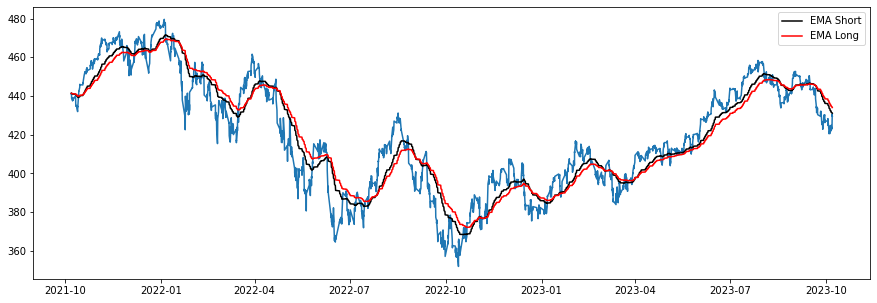

In [ ]:
#downlaod data
ticker = yf.Ticker('SPY')
df = ticker.history(interval = '1h', period = '2y')

#reset index
df = df.reset_index()

#rename the index and reset it
df = df.rename_axis("Date").reset_index()

#make columns lowercase
df.columns = [x.lower() for x in df.columns]

#create sma
df['sma'] = df['close'].rolling(60).mean()

#create two emas short and long
df['emas'] = df['close'].ewm(60, adjust = False).mean()
df['emal'] = df['close'].ewm(90, adjust = False).mean()


#plot the results
plt.figure(figsize = (15, 5))
plt.plot(df['date'], df['close'])
plt.plot(df['date'], df['emas'], c = 'k', label = 'EMA Short')
plt.plot(df['date'], df['emal'], c = 'r', label = 'EMA Long')
plt.legend()
plt.show()

In [13]:
#create min and maximas 
df = utils.create_targets(df, target_winloss = [20, 0])

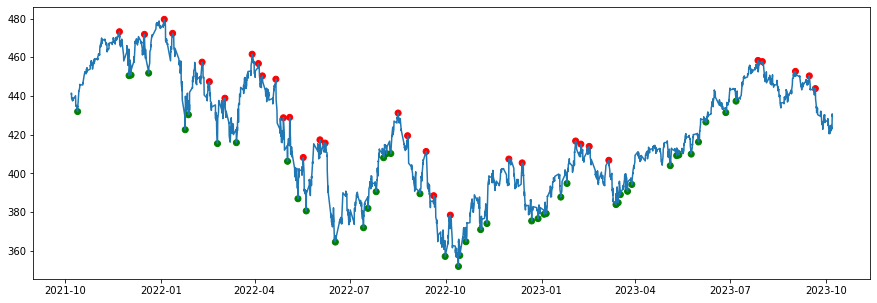

In [14]:
#plot
#plot the results
colors = {0: 'None', 1: 'green', 2: 'red'}

plt.figure(figsize = (15, 5))
plt.plot(df['date'], df['close'])
plt.scatter(df['date'], df['close'], c = df['target'].apply(lambda x: colors[x]))
plt.show()

In [15]:
#generate trends to create labels for trending up, trending down and neutral areas

def generate_trends(data):
    
    data['trend'] = 0

    targets = data['target'].values

    min_indices = np.where(targets == 1)[0]

    max_indices = np.where(targets == 2)[0]

    ind_dict = {}

    for i in min_indices:
        ind_dict[i] = 1

    for i in max_indices:
        ind_dict[i] = 2

    sorted_dict = {k: ind_dict[k] for k in sorted(ind_dict)}

    current_ind = next(iter(sorted_dict))
    current_trend = sorted_dict[current_ind]


    for i, trend in sorted_dict.items():

        if current_trend == trend:
            continue
        elif (current_trend == 1) and (trend == 2):
            data.loc[current_ind:i, 'trend'] = 1
            current_ind = i
            current_trend = trend
        elif (current_trend == 2) and (trend == 1):
            data.loc[current_ind:i, 'trend'] = 2
            current_ind = i
            current_trend = trend
            
    return data['trend'].to_list()

<Figure size 1080x216 with 0 Axes>

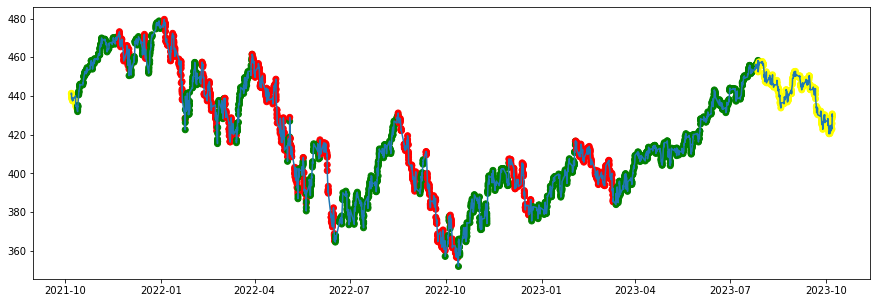

In [16]:
#create trend data and plot them
df['trend'] = np.nan
df['trend'] = generate_trends(df)

#pplot
plt.figure(figsize = (15, 3))

data_plot = df
colors = {0: 'yellow', 1: 'green', 2: 'red'}

plt.figure(figsize = (15, 5))
plt.plot(data_plot['date'], data_plot['close'])
plt.scatter(data_plot['date'], data_plot['close'], c = data_plot['trend'].apply(lambda x: colors[x]))
plt.show()

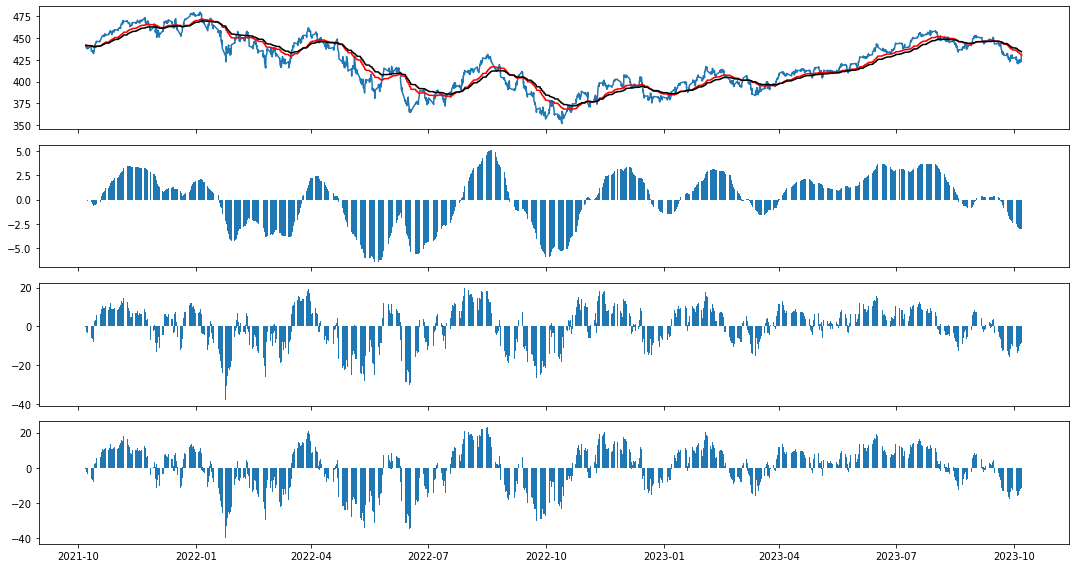

In [17]:
#create ema diffs and plot them
df['ma_diff'] = df['emas'] - df['emal']
df['cps_diff'] = df['close'] - df['emas']
df['cpl_diff'] = df['close'] - df['emal']

#plot the data to visualize
plot_data = df

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex = True, figsize = (15, 8))
ax1.plot(plot_data['date'], plot_data['close'])
ax1.plot(plot_data['date'], plot_data['emas'], color = 'r')
ax1.plot(plot_data['date'], plot_data['emal'], color = 'k')
ax2.bar(plot_data['date'], plot_data['ma_diff'])
ax3.bar(plot_data['date'], plot_data['cps_diff'])
ax4.bar(plot_data['date'], plot_data['cpl_diff'])
plt.tight_layout()
plt.show()

In [18]:
#define when all variables are positive its a buy zone and all negative its a sell zone and the rest as neutral and plot results

#create signs
df['sign'] = 0

df['sign'] = [1 if (x > 0) and (y > 0) and (z > 0) else 2 if (x < 0) and (y < 0) and (z < 0) else 0 for (x, y, z) in\
                    zip(df['ma_diff'], df['cps_diff'], df['cpl_diff'])]

<Figure size 1080x360 with 0 Axes>

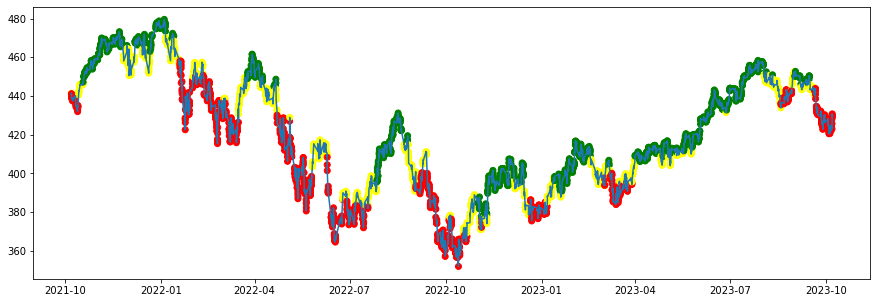

In [19]:
#plot results from the model
plt.figure(figsize = (15, 5))

data_plot = df

colors = {0: 'yellow', 1: 'green', 2: 'red'}

plt.figure(figsize = (15, 5))
plt.plot(data_plot['date'], data_plot['close'])
plt.scatter(data_plot['date'], data_plot['close'], c = data_plot['sign'].apply(lambda x: colors[x]))
plt.show()

In [20]:
#find the accuracy of the prediction from the method
from sklearn.metrics import accuracy_score

true_labels = df['trend'].to_list()
predicted_labels = df['sign'].to_list()

print(f"accuracy score: {accuracy_score(true_labels, predicted_labels)}")

accuracy score: 0.4819139846197664


In [23]:
#lets try to optimize and find the best ema lines that has the highest accuracy

#optimize using gradient tape
def predict_trend(ema1, ema2, data):
    
    data['emas'] = data['close'].ewm(ema1, adjust = False).mean()
    data['emal'] = data['close'].ewm(ema2, adjust = False).mean()
    
    data['ma_diff'] = data['emas'] - data['emal']
    data['cps_diff'] = data['close'] - data['emas']
    data['cpl_diff'] = data['close'] - data['emal']
    
    data['sign'] = [1 if (x > 0) and (y > 0) and (z > 0) else 2 if (x < 0) and (y < 0) and (z < 0) else 0 for (x, y, z) in\
                    zip(data['ma_diff'], data['cps_diff'], data['cpl_diff'])]
    
    return data['sign'].to_list()

def calculate_accuracy(targets, predictions):
    return accuracy_score(targets, predictions)      

#testing functions
pred_labels = predict_trend(90, 120, df)
calculate_accuracy(pred_labels, true_labels)

0.4477356878382227

## Brute force method to find the best 'emas' and 'emal' variables

In [24]:
#optimization procedure
from itertools import permutations

# Define the range of integer values
min_value = 30
max_value = 200

# Generate all permutations of two integers within the specified range
parameter_values = range(min_value, max_value + 1)
parameter_permutations = list(permutations(parameter_values, 2))

# Create a set to store unique pairs
unique_pairs = set()

# Iterate through the list of permutations and add unique pairs to the set
for perm in parameter_permutations:
    unique_pairs.add(tuple(sorted(perm)))
    
unique_pairs = list(unique_pairs)

#collect results
results = []

for pp in unique_pairs:
    
    #calculate the accuracy
    p1, p2 = pp
    pred_labels = predict_trend(p1, p2, df)
    acc = calculate_accuracy(pred_labels, true_labels)
    
    results.append([p1, p2, acc])

In [25]:
#plot the results
r = np.array(results)
max_acc_ind = np.argmax(r[:, 2])

print(f"Max accuracy is given by pair: {r[max_acc_ind]}")

Max accuracy is given by pair: [30.         31.          0.55539732]


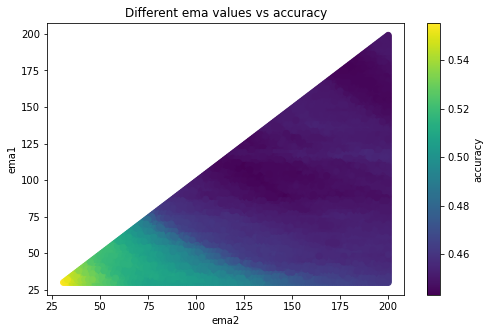

In [33]:
#plot results
x = r[:, 1]
y = r[:, 0]
intensity = r[:, 2]

plt.figure(figsize = (8, 5))
plt.scatter(x, y, c = intensity, cmap = 'viridis')
plt.title('Different ema values vs accuracy')
plt.xlabel('ema2')
plt.ylabel('ema1')
cbar = plt.colorbar()
cbar.set_label("accuracy")

In [36]:
#change sign based on new ema
df['emas'] = df['close'].ewm(30, adjust = False).mean()
df['emal'] = df['close'].ewm(31, adjust = False).mean()

#create ema diffs and plot them
df['ma_diff'] = df['emas'] - df['emal']
df['cps_diff'] = df['close'] - df['emas']
df['cpl_diff'] = df['close'] - df['emal']

#create signs
df['sign'] = 0
df['sign'] = [1 if (x > 0) and (y > 0) and (z > 0) else 2 if (x < 0) and (y < 0) and (z < 0) else 0 for (x, y, z) in\
                    zip(df['ma_diff'], df['cps_diff'], df['cpl_diff'])]

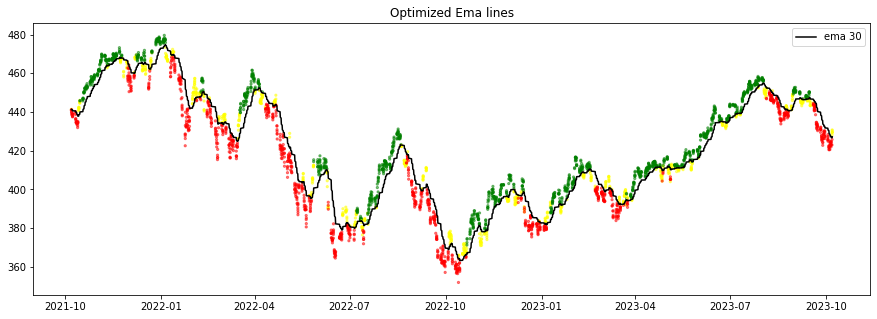

In [43]:
#plot the results
plt.figure(figsize = (15, 5))
colors = {0: 'yellow', 1: 'green', 2: 'red'}
plt.title('Optimized Ema lines')
# plt.plot(df['date'], df['close'])
# plt.plot(df['date'], df['emal'], color = 'k', label = 'ema 31')
plt.plot(df['date'], df['emas'], color = 'k', label = 'ema 30')
plt.scatter(df['date'], df['close'], c = df['sign'].apply(lambda x: colors[x]), s = 5, alpha = 0.5)
plt.legend()
plt.show()